# Quantum Amplitude Estimation (QAE) for Option Pricing

**Main task**: Evaluate European option prices via Quantum Monte Carlo simulation. We consider the payoff function $f(S_T) = \max(S_T-K,0)$, where $K$ is the strike price. The stock price $S_T$ follows Geometric Brownian Motion:

$\begin{equation}S_T = S_0\exp\left((r-\frac{\sigma^2}{2})T+\sigma W_T\right)\end{equation}$

Where:
- $W_T$: Brownian motion following a normal distribution $N(0, T)$.
- $r$: Risk-free interest rate.
- $\sigma$: Volatility.

The discounted option price is computed as $V_0 = e^{-rT}\mathbb{E}[f(S_T)]$ and estimated with QAE. The quantum result is then validated against the analytical solution of the Black-Scholes PDE given by:

$\begin{equation}V_0 = S_0\Phi(d_1)-Ke^{-rT}\Phi(d_2)\end{equation}$

where $\Phi(d)$ is the cumulative distribution function of the normal distribution defined as: $\Phi(d) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{d} e^{\frac{-x^2}{2}}\, dx$, and: 

$\begin{equation}d_1 = \frac{\ln(\frac{S_0}{K})+(r+\frac{\sigma^2}{2})T}{\sigma \sqrt{T}}\end{equation}$
$\begin{equation}d_2 = d_1 - \sigma\sqrt{T}\end{equation}$

To estimate the expectation value $\mathbb{E}[f(S_T)] = \int_{-\infty}^{\infty}p_T(x)v(x)\, dx$, where:
 
$\begin{equation}p_T(x) = \frac{1}{\sqrt{2\pi T}}e^{\frac{-x^2}{2T}}\end{equation}$ 

$\begin{equation}v(x) = \max\{S_0\exp\left((r-\frac{\sigma^2}{2})T+\sigma x\right)-K, 0\}\end{equation}$

We prepare the superposition state:

$\begin{equation}\ket{\chi} = F\ket{0}^{\otimes n+1} = \sum_{j=0}^{2^n-1}\sqrt{p_T(x_j)}\ket{x_j}(\sqrt{1-v(x_j)}\ket{0}+\sqrt{v(x_j)}\ket{1})\end{equation}$

for some discrete stock fluctuations $x_j = -x_{max}+j\cdot \frac{2x_{max}}{2^n-1}, \quad j = 0,1,\dots , 2^n-1$.

The expectation value $\mu$ is defined by the probability of measuring the ancilla qubit in the $\ket{1}$ state. However, direct sampling does not provide any complexity advantage over classical Monte Carlo simulations. Therefore, we leverage QAE to achieve a quadratic speedup. To estimate $\mu$ with QAE, we introduce an operator $V = \mathbb{I}_{2^{n+1}}-2\mathbb{I}_{2^n}\ket{1}\bra{1}$ and the transformed state: 

$\begin{equation} V\ket{\chi} = \cos(\frac{\theta}{2})\ket{\chi} + \sin(\frac{\theta}{2})\ket{\chi^\perp} \end{equation}$

We utilize the following relation to obtain $\mu$:

$\begin{equation} \bra{\chi}V\ket{\chi} = 1-2\mu = \cos(\frac{\theta}{2}) \end{equation}$

The core of this algorithm is to encode $\theta$ as the phase of an eigenvalue of the rotation operator $Q$, acting on the plane spanned by $\ket{\chi}$ and $V\ket{\chi}$. This way, we can use Quantum Phase Estimation (QPE) to estimate $\theta$ and therefore infer the expectation value $\mu$.

$Q$ is composed of a reflection about $V\ket{\chi}$ (denoted as $-S$) followed by a reflection about $\ket{\chi}$ (denoted as $-U$):

$\begin{equation} Q = (-U)(-S) = UVUV\end{equation}$

Reference: [Rebentrost et al. (2018)](https://arxiv.org/abs/1805.00109)

In [1]:
import cudaq
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Consider the following parameters:

In [2]:
# Option parameters
T = 1
sigma = 0.2
r = 0.05
K = 80
S0 = 100

## 1. Load the probability distribution  
First, we prepare a superposition state whose amplitudes follow the normal distribution $p_T(x)$. The quantum state preparation algorithm is inspired by [Grover et al. (2002)](https://arxiv.org/pdf/quant-ph/0208112)

In [3]:
n = 4 # number of qubits used to discretize the random variable x in a normal distribution
x_max = 2  # boundary of the distribution

# partition points for different levels of resolution
partitions = [[-x_max, 0, x_max]]
for _ in range(n-1):
    new_partition = []
    old_partition = partitions[-1].copy()
    for i in range(len(old_partition)-1):
        new_partition.append(old_partition[i])
        new_partition.append((old_partition[i]+old_partition[i+1])/2)
    new_partition.append(old_partition[-1])
    partitions.append(new_partition)
print("Partition edges of the distribution", partitions[-1])

# rotation angles applied to the circuit for loading p_T
pT_angles = []
for partition in partitions:
    for i in range(1, len(partition), 2):
        base = stats.norm.cdf(partition[i+1],scale=T**0.5) - stats.norm.cdf(partition[i-1],scale=T**0.5)
        pT_angles.append(2*np.arcsin(((stats.norm.cdf(partition[i+1],scale=T**0.5)-stats.norm.cdf(partition[i],scale=T**0.5))/base)**0.5))
        

Partition edges of the distribution [-2, -1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]


In [4]:
@cudaq.kernel
def load_pT(qvector: cudaq.qvector, pT_angles: list[float]):
    
    n = qvector.size()-1 # number of qubits used to load the distribution (exluding ancilla qubit)
    
    for lvl in range(n):
        angles = pT_angles[2**lvl-1:2**(lvl+1)-1]
        if lvl == 0:
            ry(angles[0],qvector[n-1])
        else:
            for idx in range(2**lvl):
                # flip control qubits that should be |0> in the control state
                for j in range(lvl):
                    bit = (idx >> j) & 1  # LSB on the left (j=0)
                    if bit == 0:
                        x(qvector[n - lvl + j])
                        
                ry.ctrl(angles[idx],qvector[n-lvl:n],qvector[n-1-lvl])
                        
                # undo the flips on control qubits
                for j in range(lvl):
                    bit = (idx >> j) & 1
                    if bit == 0:
                        x(qvector[n - lvl + j]) 
                    

visualze the circuit and the resulting distribution

In [5]:
@cudaq.kernel
def plot_load_pT(n: int, pT_angles: list[float]):
    qvector = cudaq.qvector(n+1)
    load_pT(qvector, pT_angles)

print(cudaq.draw(plot_load_pT,n,pT_angles))
# get the statevector
state = cudaq.get_state(plot_load_pT,n,pT_angles)
probabilities = np.abs(state)**2
dist = probabilities[:2**n]  # exclude the ancilla qubit

                                                                            »
q0 : ───────────────────────────────────────────────────────────────────────»
                                                           ╭──────────╮     »
q1 : ──────────────────────────────────────────────────────┤ ry(1.93) ├─────»
                       ╭───────────╮     ╭───────────╮╭───╮╰────┬─────╯╭───╮»
q2 : ──────────────────┤ ry(2.016) ├─────┤ ry(1.126) ├┤ x ├─────●──────┤ x ├»
     ╭───────────╮╭───╮╰─────┬─────╯╭───╮╰─────┬─────╯├───┤     │      ├───┤»
q3 : ┤ ry(1.571) ├┤ x ├──────●──────┤ x ├──────●──────┤ x ├─────●──────┤ x ├»
     ╰───────────╯╰───╯             ╰───╯             ╰───╯            ╰───╯»

################################################################################

                                                           ╭───────────╮     »
───────────────────────────────────────────────────────────┤ ry(1.787) ├─────»
     ╭───────────╮     ╭───────────╮     ╭───────────╮╭──

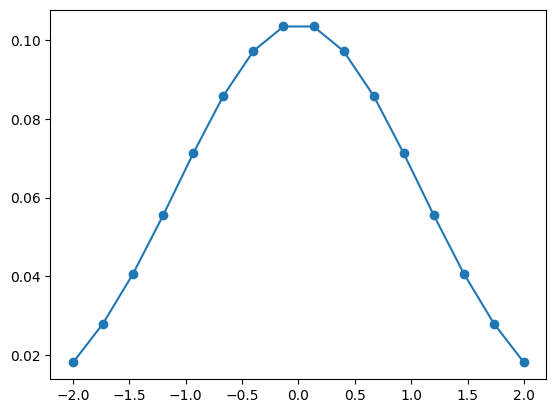

In [6]:
x_points = [-x_max+ j*2*x_max/(2**n-1) for j in range(2**n)]
plt.plot(x_points,dist, marker="o")

## 2. Compute the payoff function 
We normalize the payoff function $f(S_T)$ such that its values lie within the range $[0, 1]$, allowing the outputs to be encoded as amplitudes of the ancilla qubit via controlled-rotations. The rotation angle satisfies $\sin^{2}(\theta_{j}/2) = v(x_j)$ 

In [7]:
# payoff function
f_ST =  lambda x: max(0, S0*np.exp((r-sigma**2/2)*T+sigma*x)-K)
f_ST = np.vectorize(f_ST)

# rescale f_ST(x) to the range [0,1]
# the final output needs to be multiplied by f_max
f_max = max(f_ST(x_points))
v_x = f_ST(x_points)/f_max
print("normalized payoffs: ",v_x)
vx_angles = 2*np.arcsin(v_x**0.5)

normalized payoffs:  [0.         0.         0.         0.01369863 0.06849315 0.1369863
 0.20547945 0.2739726  0.34246575 0.42465753 0.50684932 0.60273973
 0.68493151 0.79452055 0.89041096 1.        ]


In [9]:
@cudaq.kernel
def compute_payoff(qvector: cudaq.qvector, vx_angles: list[float]):
    
    n = qvector.size() - 1
    
    for idx in range(len(vx_angles)):
      if vx_angles[idx] !=0:
        for j in range(n):  # n control-bits
          # flip control qubits that should be |0> in the control state
          bit = (idx >> j) & 1  
          if bit == 0:
              x(qvector[j])  
                
        ry.ctrl(vx_angles[idx], qvector[:n],qvector[n])
              
        # undo the flips on control qubits
        for j in range(n): 
          bit = (idx >> j) & 1  
          if bit == 0:
              x(qvector[j]) 

In [10]:
@cudaq.kernel
def plot_payoff(n:int, vx_angles:list[float]):
    qvector = cudaq.qvector(n+1)
    compute_payoff(qvector, vx_angles)
    
print(cudaq.draw(plot_payoff,4,vx_angles))

                        ╭───╮                   ╭───╮                   ╭───╮»
q0 : ───────────●───────┤ x ├───────────●───────┤ x ├───────────●───────┤ x ├»
                │       ├───┤           │       ├───┤╭───╮      │       ├───┤»
q1 : ───────────●───────┤ x ├───────────●───────┤ x ├┤ x ├──────●───────┤ x ├»
     ╭───╮      │       ├───┤           │       ╰───╯╰───╯      │       ╰───╯»
q2 : ┤ x ├──────●───────┤ x ├───────────●───────────────────────●────────────»
     ├───┤      │       ├───┤╭───╮      │       ╭───╮╭───╮      │       ╭───╮»
q3 : ┤ x ├──────●───────┤ x ├┤ x ├──────●───────┤ x ├┤ x ├──────●───────┤ x ├»
     ╰───╯╭─────┴──────╮╰───╯╰───╯╭─────┴──────╮╰───╯╰───╯╭─────┴──────╮╰───╯»
q4 : ─────┤ ry(0.2346) ├──────────┤ ry(0.5296) ├──────────┤ ry(0.7583) ├─────»
          ╰────────────╯          ╰────────────╯          ╰────────────╯     »

################################################################################

                   ╭───╮                  ╭───╮ 

Combine distribution loading and payoff computation to form the operator $F$ : $\ket{\chi} = F\ket{0}^{\otimes n+1}$

In [11]:
@cudaq.kernel
def F(qvector: cudaq.qvector, pT_angles: list[float], vx_angles: list[float]):
    load_pT(qvector,pT_angles)
    compute_payoff(qvector,vx_angles)

## 3. Construct the rotation operator $Q$
The eigenvalues of $Q$ are $e^{\pm i \theta}$. Since $\ket{\chi}$ can be expressed as a linear combination of $Q$'s eigenstates, the output of QPE, with  $\ket{\chi}$ being the input, consists of two major phases $\pm \theta$.

$Q = (-U)(-S) = UVUV$, where $U = \mathbb{I}_{2^{n+1}} - 2\ket{\chi}\bra{\chi}$ and $S = \mathbb{I}_{2^{n+1}} - 2V\ket{\chi}\bra{\chi}V$

$U$ can be implemented with $FZF^{\dagger}$, with $Z = \mathbb{I}_{2^{n+1}}-2\ket{0^{n+1}}\bra{0^{n+1}}$

In [12]:
@cudaq.kernel
def Q(qvector: cudaq.qvector, pT_angles: list[float], vx_angles: list[float]):
    
    for _ in range(2):
        # V: flip the phases of the states whose ancilla qubit = |1>
        x.ctrl(qvector[-1],qvector[0])
        z.ctrl(qvector[-1],qvector[0])
        x.ctrl(qvector[-1],qvector[0])
        z.ctrl(qvector[-1],qvector[0])
        
        # U
        cudaq.adjoint(F,qvector,pT_angles, vx_angles)
        x(qvector)
        z.ctrl(qvector[:-1],qvector[-1])
        x(qvector)
        F(qvector, pT_angles, vx_angles)
        

## 4. Implement QAE
QAE is a variant of QPE where the unitary operator is the Grover rotation operator $Q$. In this case, the QAE circuit utilizes a $p$-bit precision register to output an integer $y \in \{0, \dots, 2^p-1\}$, which is related to the phase $\theta$ by the relation: 

$$y = \frac{2^p \theta}{2\pi}$$

Once we obtain $\theta$, we can calculate the amplitudes of $V\ket{\chi} = \cos(\frac{\theta}{2})\ket{\chi} + \sin(\frac{\theta}{2})\ket{\chi^\perp}$

First, we need the inverse Quantum Fourier Transform (QFT) in QAE

In [13]:
@cudaq.kernel
def QFT(qvector: cudaq.qvector):
    n= len(qvector)
    for i in range(n):
        h(qvector[n-1-i])
        for j in range(i + 1, n):
            angle = (2 * np.pi) / (2**(j - i + 1))
            r1.ctrl(angle, qvector[n-1-j], qvector[n-1-i]) # phase-shift gate
    
    # reverse qubit order
    for i in range(n//2):
        swap(qvector[i],qvector[n-1-i])
                      
@cudaq.kernel
def inverse_QFT(qvector: cudaq.qvector):
    cudaq.adjoint(QFT, qvector)

Finally, we put everything together

In [14]:
@cudaq.kernel
def QAE(num_chi: int, num_phase: int, pT_angles: list[float], vx_angles: list[float]):
    
    phase_qubits = cudaq.qvector(num_phase) # quantum register for phase estimation
    chi_qubits = cudaq.qvector(num_chi)  # quantum register for |χ>
    
    h(phase_qubits)
    F(chi_qubits,pT_angles,vx_angles)
    
    for i in range(num_phase):
        for _ in range(2**i):
            cudaq.control(Q,phase_qubits[i],chi_qubits,pT_angles,vx_angles)
            
    inverse_QFT(phase_qubits)
    mz(phase_qubits)
    

peaks (y, probability): [(19, 0.3968), (13, 0.3866)]


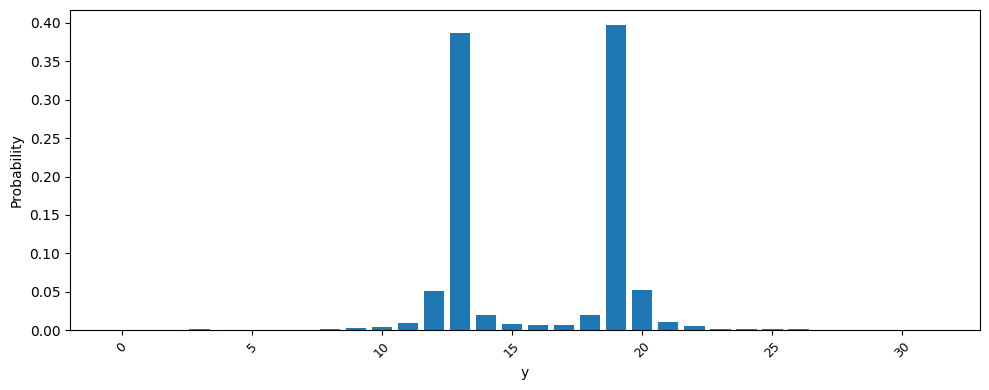

In [ ]:
precision = 5  # we use a 5-bit precision register
shots = 10000
result = cudaq.sample(QAE, n+1, precision, pT_angles, vx_angles,shots_count=shots)
prob_dict = {int(k[::-1],2):v/shots for k,v in result.items()}

peaks = sorted(prob_dict.items(), key=lambda item: item[1], reverse=True)[:2]
print(f"peaks (y, probability): {peaks}")

sorted_y = sorted(prob_dict.items(), key=lambda x: x[0], reverse=True)

y = [item[0] for item in sorted_y]
probs = [item[1] for item in sorted_y]

plt.figure(figsize=(10, 4)) 
plt.bar(y, probs)

plt.xticks(rotation=45, fontsize=9)
plt.xlabel('y')
plt.ylabel('Probability')

plt.tight_layout()

The QAE measurement yields two primary peaks at $y_1=13$ and $y_2=19$. These phases represent opposite amplitudes $\cos(\alpha)$ and $\cos(\pi-\alpha)$, where $\alpha = \frac{13}{32}\pi$. For our estimation, we select the positive branch ($\alpha$) to derive the final expectation value. 

## 5. Post-processing and validation
We can compute the expectation value using Eq. (9) and the normalization factor `f_max`. The estimated option price is then validated against the analytical option price. 

In [28]:
# calculate the estimated option price
output = min(peaks[0][0],peaks[1][0])
theta = 2*np.pi*output/2**precision
prob = np.cos(theta/2)
expectation = (1 - prob)*f_max/2 
V0_estimate = expectation * np.exp(-r*T)
print("estimated option price: ",V0_estimate)

# calculate analytical option price (solution of Black-Schole's PDE)
d1 = (np.log(S0/K)+(r+sigma**2/2)*T)/(sigma*T**0.5)
d2 = d1- sigma*T**0.5
cdf_d1 = stats.norm.cdf(d1)
cdf_d2 = stats.norm.cdf(d2)
V0 = S0*cdf_d1 -K*np.exp(-r*T)*cdf_d2
print("analytical option price:",V0)
print(f"error: {abs(V0_estimate-V0)/V0}")

estimated option price:  24.641226577532038
analytical option price: 24.58883544392775
error: 0.0021306878775841608
